# saved models are named as FreeSound_1D_conv_

In [1]:
import os
import pickle
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
os.listdir('data/freesound-audio-tagging')

['audio_test',
 'audio_train',
 'free_sound_11025.pkl',
 'free_sound_22050.pkl',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv']

In [2]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [15]:
pickle.dump(Loaded_data, open('data/freesound-audio-tagging/free_sound_11025.pkl', 'wb'))

In [3]:
Loaded_data = {}
if os.path.exists('data/freesound-audio-tagging/free_sound_11025.pkl'):
    Loaded_data = pickle.load(open('data/freesound-audio-tagging/free_sound_11025.pkl', 'rb'))
    
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

def load_audio_file(file_path, input_length=4096):
    
    if file_path not in Loaded_data:
        data = librosa.core.load(file_path, sr=None) 
        data = librosa.core.resample(data[0], data[1], 11025)
        Loaded_data[file_path] = data
    else:
        data = Loaded_data[file_path]
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

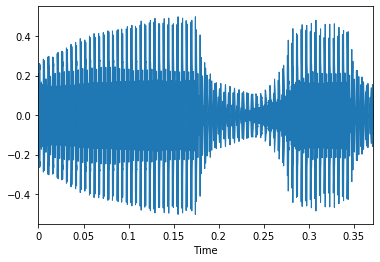

In [5]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=11025, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [6]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [7]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.input_length = 4096
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return load_audio_file(file_path), label_indice
        

In [8]:
sr = 11025
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = sr/2):
    return_signal = np.zeros((8, self.input_length))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [9]:
mini_batch_size = 96
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=mini_batch_size, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=mini_batch_size, shuffle=True)

In [10]:
FreeSoundData[0][0].shape

(1, 4096)

# Model

In [11]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_32_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_96_3 = nn.Conv1d(in_channels=32, out_channels=96, kernel_size=3, padding=True)
        self.conv1d_96_96_3 = nn.Conv1d(in_channels=96, out_channels=96, kernel_size=3, padding=True)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_96_64 = nn.Linear(in_features=96, out_features=64)
        self.fc_64_512 = nn.Linear(in_features=64, out_features=512)
        self.fc_512_42 = nn.Linear(in_features=512, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_96_3(x)
        x = self.relu(x)
        x = self.conv1d_96_96_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = torch.mean(x, 2)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_96_64(x)
        x = self.relu(x)
        x = self.fc_64_512(x)
        x = self.relu(x)
        x = self.fc_512_42(x)
        x = self.softmax(x)
        
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 4096))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 4090]             160
              ReLU-2             [-1, 16, 4090]               0
            Conv1d-3             [-1, 16, 4084]           2,320
              ReLU-4             [-1, 16, 4084]               0
         MaxPool1d-5              [-1, 16, 255]               0
           Dropout-6              [-1, 16, 255]               0
            Conv1d-7              [-1, 32, 255]           1,568
              ReLU-8              [-1, 32, 255]               0
            Conv1d-9              [-1, 32, 255]           3,104
             ReLU-10              [-1, 32, 255]               0
        MaxPool1d-11               [-1, 32, 63]               0
          Dropout-12               [-1, 32, 63]               0
           Conv1d-13               [-1, 32, 63]           3,104
             ReLU-14               [-1,

In [23]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.00005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [24]:
epoch_progress_bar = tqdm.tqdm(range(0, 500))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*mini_batch_size)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*mini_batch_size)))


Epoch Loss:  3.4789389990553072
Train Acc  29.654535864978904



Valid Acc  30.0



Epoch Loss:  3.4756984016563317
Train Acc  30.327004219409282



Valid Acc  30.260416666666668



Epoch Loss:  3.4730634206457984
Train Acc  30.432489451476794



Valid Acc  28.59375



Epoch Loss:  3.4822513242311115
Train Acc  29.628164556962027



Valid Acc  28.125



Epoch Loss:  3.47228808342656
Train Acc  30.511603375527425



Valid Acc  28.958333333333332



Epoch Loss:  3.4758023581927335
Train Acc  30.181962025316455



Valid Acc  30.364583333333332



Epoch Loss:  3.4753443138508855
Train Acc  30.26107594936709



Valid Acc  28.958333333333332



Epoch Loss:  3.475061621847032
Train Acc  30.155590717299578



Valid Acc  29.0625



Epoch Loss:  3.4782840571826017
Train Acc  29.997362869198312



Valid Acc  29.739583333333332



Epoch Loss:  3.4766957699498042
Train Acc  30.036919831223628



Valid Acc  28.541666666666668



Epoch Loss:  3.4760450713242155
Train Acc  30.181962025316455



Valid Acc  29.739583333333332



Epoch Loss:  3.473258613031122
Train Acc  30.300632911392405



Valid Acc  29.6875



Epoch Loss:  3.470933606352987
Train Acc  30.537974683544302



Valid Acc  29.479166666666668



Epoch Loss:  3.4752178765550443
Train Acc  30.498417721518987



Valid Acc  29.947916666666668



Epoch Loss:  3.479706848723979
Train Acc  29.760021097046412



Valid Acc  29.84375



Epoch Loss:  3.470650540122503
Train Acc  30.68301687763713



Valid Acc  28.229166666666668



Epoch Loss:  3.470153201984454
Train Acc  30.80168776371308



Valid Acc  30.0



Epoch Loss:  3.477571843545648
Train Acc  29.944620253164558



Valid Acc  30.052083333333332



Epoch Loss:  3.469858211807058
Train Acc  30.775316455696203



Valid Acc  28.75



Epoch Loss:  3.476740001123163
Train Acc  30.063291139240505



Valid Acc  30.78125



Epoch Loss:  3.4765277452106718
Train Acc  30.26107594936709



Valid Acc  31.197916666666668



Epoch Loss:  3.4758255542079106
Train Acc  30.24789029535865



Valid Acc  28.59375



Epoch Loss:  3.4722202820113943
Train Acc  30.537974683544302



Valid Acc  29.375



Epoch Loss:  3.4741906123825266
Train Acc  30.26107594936709



Valid Acc  29.635416666666668



Epoch Loss:  3.4754316323920142
Train Acc  30.234704641350213



Valid Acc  29.375



Epoch Loss:  3.4741686144961585
Train Acc  30.39293248945148



Valid Acc  29.21875



Epoch Loss:  3.478649673582632
Train Acc  29.944620253164558



Valid Acc  29.895833333333332



Epoch Loss:  3.4736535187009014
Train Acc  30.35337552742616



Valid Acc  28.958333333333332



Epoch Loss:  3.4730570618110366
Train Acc  30.327004219409282



Valid Acc  31.145833333333332



Epoch Loss:  3.4720225092730943
Train Acc  30.59071729957806



Valid Acc  29.895833333333332



Epoch Loss:  3.480635117880906
Train Acc  29.641350210970465



Valid Acc  28.75



Epoch Loss:  3.470291001887261
Train Acc  30.66983122362869



Valid Acc  30.208333333333332



Epoch Loss:  3.4801694924318336
Train Acc  29.720464135021096



Valid Acc  29.375



Epoch Loss:  3.4729207075094877
Train Acc  30.735759493670887



Valid Acc  28.854166666666668



Epoch Loss:  3.4754112853279597
Train Acc  30.24789029535865



Valid Acc  28.90625



Epoch Loss:  3.476842098598239
Train Acc  30.195147679324894



Valid Acc  29.375



Epoch Loss:  3.4723322331150874
Train Acc  30.498417721518987



Valid Acc  30.104166666666668



Epoch Loss:  3.4693521940255465
Train Acc  30.893987341772153



Valid Acc  30.3125



Epoch Loss:  3.4684543730337407
Train Acc  30.893987341772153



Valid Acc  29.114583333333332



Epoch Loss:  3.4720260342465172
Train Acc  30.39293248945148



Valid Acc  29.947916666666668



Epoch Loss:  3.4754265199733685
Train Acc  30.208333333333332



Valid Acc  29.166666666666668



Epoch Loss:  3.476998944825764
Train Acc  30.076476793248943



Valid Acc  28.385416666666668



Epoch Loss:  3.4736659557004517
Train Acc  30.45886075949367



Valid Acc  29.114583333333332



Epoch Loss:  3.470871813689606
Train Acc  30.70938818565401



Valid Acc  27.604166666666668



Epoch Loss:  3.474743577498424
Train Acc  30.116033755274263



Valid Acc  29.583333333333332



Epoch Loss:  3.4736381150499174
Train Acc  30.406118143459917



Valid Acc  28.697916666666668



Epoch Loss:  3.476859720447395
Train Acc  29.997362869198312



Valid Acc  29.010416666666668



Epoch Loss:  3.4729172036617615
Train Acc  30.45886075949367



Valid Acc  30.729166666666668



Epoch Loss:  3.466513802733602
Train Acc  31.091772151898734



Valid Acc  29.166666666666668



Epoch Loss:  3.4710891759848295
Train Acc  30.656645569620252



Valid Acc  29.375



Epoch Loss:  3.4725186583362047
Train Acc  30.66983122362869



Valid Acc  29.53125



Epoch Loss:  3.4705800708336167
Train Acc  30.72257383966245



Valid Acc  29.947916666666668



Epoch Loss:  3.472075079060808
Train Acc  30.45886075949367



Valid Acc  30.052083333333332



Epoch Loss:  3.4752737600592116
Train Acc  30.234704641350213



Valid Acc  30.833333333333332



Epoch Loss:  3.4764023128944106
Train Acc  30.102848101265824



Valid Acc  30.520833333333332



Epoch Loss:  3.4752258258529856
Train Acc  30.366561181434598



Valid Acc  29.895833333333332



Epoch Loss:  3.478755667239805
Train Acc  29.825949367088608



Valid Acc  31.302083333333332



Epoch Loss:  3.474501111839391
Train Acc  30.27426160337553



Valid Acc  29.791666666666668



Epoch Loss:  3.4748225031019766
Train Acc  30.195147679324894



Valid Acc  30.364583333333332



Epoch Loss:  3.4705434720727464
Train Acc  30.814873417721518



Valid Acc  30.0



Epoch Loss:  3.4747669576089595
Train Acc  30.27426160337553



Valid Acc  30.15625



Epoch Loss:  3.471718773057189
Train Acc  30.59071729957806



Valid Acc  29.791666666666668



Epoch Loss:  3.4748619991012766
Train Acc  30.234704641350213



Valid Acc  29.583333333333332



Epoch Loss:  3.4734953234467327
Train Acc  30.445675105485233



Valid Acc  30.416666666666668



Epoch Loss:  3.473983212362362
Train Acc  30.34018987341772



Valid Acc  29.635416666666668



Epoch Loss:  3.4743585435650015
Train Acc  30.287447257383967



Valid Acc  28.75



Epoch Loss:  3.474212737023076
Train Acc  30.35337552742616



Valid Acc  30.0



Epoch Loss:  3.4761449475831623
Train Acc  30.116033755274263



Valid Acc  30.208333333333332



Epoch Loss:  3.4692167662367037
Train Acc  30.841244725738395



Valid Acc  28.489583333333332



Epoch Loss:  3.468991717205772
Train Acc  30.90717299578059



Valid Acc  30.15625



Epoch Loss:  3.4708293118054354
Train Acc  30.735759493670887



Valid Acc  30.520833333333332



Epoch Loss:  3.4692384562914884
Train Acc  30.828059071729957



Valid Acc  29.53125



Epoch Loss:  3.4750265230106403
Train Acc  30.195147679324894



Valid Acc  29.0625



Epoch Loss:  3.4731551212600515
Train Acc  30.498417721518987



Valid Acc  31.041666666666668



Epoch Loss:  3.4734503226944162
Train Acc  30.445675105485233



Valid Acc  30.833333333333332



Epoch Loss:  3.4727536968038053
Train Acc  30.445675105485233



Valid Acc  30.572916666666668



Epoch Loss:  3.47091036506846
Train Acc  30.72257383966245



Valid Acc  30.364583333333332



Epoch Loss:  3.4740576774259155
Train Acc  30.406118143459917



Valid Acc  28.90625



Epoch Loss:  3.471785397469243
Train Acc  30.617088607594937



Valid Acc  29.114583333333332



Epoch Loss:  3.474259633052198
Train Acc  30.39293248945148



Valid Acc  29.114583333333332



Epoch Loss:  3.471923767765866
Train Acc  30.57753164556962



Valid Acc  29.583333333333332



Epoch Loss:  3.4692799562140357
Train Acc  30.841244725738395



Valid Acc  30.0



Epoch Loss:  3.471167754523362
Train Acc  30.643459915611814



Valid Acc  29.6875



Epoch Loss:  3.474434746971613
Train Acc  30.537974683544302



Valid Acc  30.15625



Epoch Loss:  3.4733962077128737
Train Acc  30.445675105485233



Valid Acc  30.260416666666668



Epoch Loss:  3.4683427327795875
Train Acc  30.854430379746834



Valid Acc  29.53125



Epoch Loss:  3.470651508886603
Train Acc  30.643459915611814



Valid Acc  29.947916666666668



Epoch Loss:  3.4717896226086196
Train Acc  30.57753164556962



Valid Acc  29.21875



Epoch Loss:  3.4689410970180847
Train Acc  31.0126582278481



Valid Acc  30.416666666666668



Epoch Loss:  3.4738374631616136
Train Acc  30.34018987341772



Valid Acc  29.21875



Epoch Loss:  3.474403194234341
Train Acc  30.234704641350213



Valid Acc  29.375



Epoch Loss:  3.4724023281773433
Train Acc  30.524789029535864



Valid Acc  30.104166666666668



Epoch Loss:  3.474129305610174
Train Acc  30.287447257383967



Valid Acc  30.364583333333332



Epoch Loss:  3.472413663622699
Train Acc  30.643459915611814



Valid Acc  30.729166666666668



Epoch Loss:  3.4680524415607694
Train Acc  30.99947257383966



Valid Acc  28.541666666666668



Epoch Loss:  3.472594393959528
Train Acc  30.551160337552744



Valid Acc  30.15625



Epoch Loss:  3.478244208082368
Train Acc  29.852320675105485



Valid Acc  28.385416666666668



Epoch Loss:  3.473286028149762
Train Acc  30.27426160337553



Valid Acc  30.364583333333332



Epoch Loss:  3.472043351282047
Train Acc  30.66983122362869



Valid Acc  29.84375



Epoch Loss:  3.4696293088454233
Train Acc  30.80168776371308



Valid Acc  29.0625



Epoch Loss:  3.4669829410842703
Train Acc  31.065400843881857



Valid Acc  29.53125



Epoch Loss:  3.471324054500725
Train Acc  30.57753164556962



Valid Acc  29.6875



Epoch Loss:  3.4738645704486704
Train Acc  30.511603375527425



Valid Acc  29.53125



Epoch Loss:  3.46787658220605
Train Acc  30.959915611814345



Valid Acc  29.375



Epoch Loss:  3.4747858228562754
Train Acc  30.234704641350213



Valid Acc  29.114583333333332



Epoch Loss:  3.4686069458345825
Train Acc  31.065400843881857



Valid Acc  29.635416666666668



Epoch Loss:  3.471367875231972
Train Acc  30.511603375527425



Valid Acc  30.989583333333332



Epoch Loss:  3.4689027206807195
Train Acc  30.93354430379747



Valid Acc  30.3125



Epoch Loss:  3.4729064174845248
Train Acc  30.66983122362869



Valid Acc  31.40625



Epoch Loss:  3.473525665983369
Train Acc  30.511603375527425



Valid Acc  30.3125



Epoch Loss:  3.467366870445541
Train Acc  30.946729957805907



Valid Acc  29.166666666666668



Epoch Loss:  3.4729655302023588
Train Acc  30.524789029535864



Valid Acc  30.15625



Epoch Loss:  3.4722014469436453
Train Acc  30.57753164556962



Valid Acc  29.6875



Epoch Loss:  3.47161994101126
Train Acc  30.735759493670887



Valid Acc  29.6875



Epoch Loss:  3.4776076002966
Train Acc  30.102848101265824



Valid Acc  29.791666666666668



Epoch Loss:  3.4743687895279898
Train Acc  30.34018987341772



Valid Acc  30.677083333333332



Epoch Loss:  3.471863728535326
Train Acc  30.564345991561183



Valid Acc  30.15625



Epoch Loss:  3.4694099275371695
Train Acc  30.748945147679326



Valid Acc  29.6875



Epoch Loss:  3.4710679476774193
Train Acc  30.68301687763713



Valid Acc  29.635416666666668



Epoch Loss:  3.472483197345009
Train Acc  30.45886075949367



Valid Acc  30.3125



Epoch Loss:  3.4738551876212975
Train Acc  30.419303797468356



Valid Acc  30.46875



Epoch Loss:  3.4774420261383057
Train Acc  30.1292194092827



Valid Acc  30.052083333333332



Epoch Loss:  3.4741353837749624
Train Acc  30.287447257383967



Valid Acc  29.270833333333332



Epoch Loss:  3.4701028232333027
Train Acc  30.775316455696203



Valid Acc  29.427083333333332



Epoch Loss:  3.4726049960414067
Train Acc  30.524789029535864



Valid Acc  29.53125



Epoch Loss:  3.4705868370925326
Train Acc  30.68301687763713



Valid Acc  29.21875



Epoch Loss:  3.4678513551060157
Train Acc  30.946729957805907



Valid Acc  29.583333333333332



Epoch Loss:  3.479160314873804
Train Acc  29.865506329113924



Valid Acc  30.208333333333332



Epoch Loss:  3.469784745687171
Train Acc  30.735759493670887



Valid Acc  29.947916666666668



Epoch Loss:  3.4683286328858967
Train Acc  30.92035864978903



Valid Acc  29.166666666666668



Epoch Loss:  3.4672075585473943
Train Acc  31.184071729957807



Valid Acc  30.729166666666668



Epoch Loss:  3.478000840054283
Train Acc  29.878691983122362



Valid Acc  29.375



Epoch Loss:  3.4753234084648423
Train Acc  30.234704641350213



Valid Acc  30.208333333333332



Epoch Loss:  3.4738587820077242
Train Acc  30.406118143459917



Valid Acc  30.260416666666668



Epoch Loss:  3.4707139926620676
Train Acc  30.72257383966245



Valid Acc  30.208333333333332



Epoch Loss:  3.465692154968841
Train Acc  31.26318565400844



Valid Acc  29.375



Epoch Loss:  3.4767775867558735
Train Acc  30.089662447257385



Valid Acc  30.520833333333332



Epoch Loss:  3.48073276688781
Train Acc  29.654535864978904



Valid Acc  30.677083333333332



Epoch Loss:  3.470679651332807
Train Acc  30.66983122362869



Valid Acc  30.416666666666668



Epoch Loss:  3.476652975323834
Train Acc  30.063291139240505



Valid Acc  30.052083333333332



Epoch Loss:  3.470729912383647
Train Acc  30.775316455696203



Valid Acc  29.0625



Epoch Loss:  3.4750038551378855
Train Acc  30.155590717299578



Valid Acc  29.479166666666668



Epoch Loss:  3.4708353658265705
Train Acc  30.66983122362869



Valid Acc  30.416666666666668



Epoch Loss:  3.471999675412721
Train Acc  30.643459915611814



Valid Acc  29.479166666666668



Epoch Loss:  3.4728820354123657
Train Acc  30.35337552742616



Valid Acc  29.947916666666668



Epoch Loss:  3.472354544868952
Train Acc  30.511603375527425



Valid Acc  30.625



Epoch Loss:  3.471946752524074
Train Acc  30.537974683544302



Valid Acc  29.895833333333332



Epoch Loss:  3.470959925953346
Train Acc  30.524789029535864



Valid Acc  28.385416666666668



Epoch Loss:  3.4664340019226074
Train Acc  31.091772151898734



Valid Acc  30.052083333333332



Epoch Loss:  3.4643703080430814
Train Acc  31.50052742616034



Valid Acc  29.322916666666668



Epoch Loss:  3.472460375556463
Train Acc  30.524789029535864



Valid Acc  30.0



Epoch Loss:  3.4712685029717942
Train Acc  30.445675105485233



Valid Acc  28.541666666666668



Epoch Loss:  3.469923626018476
Train Acc  30.867616033755276



Valid Acc  29.895833333333332



Epoch Loss:  3.47015769270402
Train Acc  30.841244725738395



Valid Acc  30.052083333333332


KeyboardInterrupt: 

In [25]:
torch.save(Model.state_dict(), "model_weights/FreeSound_1D_conv_small_750_epoch.stDict")

In [174]:
i=0
for data in FreeSoundDataLoader:
    if i==4:
        O = Model(data[0].float().to(device))
        A = data[1]
        #print(data[1])
        break
    i+=1
O = O.detach().cpu().numpy()
K = np.argmax(O, axis=1)==A.numpy()
print(np.sum(K)/len(K), np.sum(K))
list(zip(A, K))

0.3125 10


[(tensor(0), False),
 (tensor(3), True),
 (tensor(12), False),
 (tensor(25), False),
 (tensor(15), True),
 (tensor(20), False),
 (tensor(4), False),
 (tensor(12), False),
 (tensor(34), False),
 (tensor(13), False),
 (tensor(24), False),
 (tensor(26), True),
 (tensor(7), False),
 (tensor(22), False),
 (tensor(40), True),
 (tensor(20), True),
 (tensor(17), True),
 (tensor(32), True),
 (tensor(7), False),
 (tensor(24), False),
 (tensor(29), False),
 (tensor(10), False),
 (tensor(38), True),
 (tensor(34), False),
 (tensor(30), True),
 (tensor(17), False),
 (tensor(26), True),
 (tensor(18), False),
 (tensor(12), False),
 (tensor(17), False),
 (tensor(1), False),
 (tensor(39), False)]